# NLP: US Airlines Tweets Sentiment Analysis


## **Context:**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

- The purpose of this analysis is to classify positive, neutral or negative sentiments from posted tweets to help US airlines in improving customer support and their services.
- Pipelines were used to automate entire process (text preprocessing, transformation, classification and tuning).
- In second part, neutral group is combined with positive for easier classification.


#### Importing libraries, loading dataset, data shape and description

In [1]:
# install and import necessary libraries.

#!conda activate name_of_your_environment
#!pip install contractions

import re, string, unicodedata                          
import contractions                                     
from bs4 import BeautifulSoup                           

import numpy as np                                      
import pandas as pd                                     
import nltk                                             

# nltk.download('stopwords')                              # Download if needed.
# nltk.download('punkt')
# nltk.download('wordnet')

#! pip install emoji
import emoji

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer         

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
sns.set_context("talk", font_scale=0.9) #for automatic larfer fonts on plots


In [5]:
df=pd.read_csv('Tweets.csv') # data loading


In [6]:
df.shape                     # shape of data.


(14640, 15)


 - Realtively small data set with almost 15,000 rows

In [7]:
df.head()    
# Printing first 5 rows of data.

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

- Many NaN missing values

In [8]:
df.isna().sum(axis=0)      # Check for NaN and NULL values.


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
df.isnull().sum(axis=0) 


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

#### Insights:
 - Luckely, there are no missing values in target columns: airline_sentiment and text
 - Also, airline column is not having missing values and will be used in EDA part only, in addition to the target columns

### Understanding data-columns: 
   1. Drop all other columns except “text” and “airline_sentiment”.
   2. Check the shape of data.
   3. Print first 5 rows of data.

In [10]:
# with airline column - see justification above 

df1=df[['airline_sentiment', 'airline', 'text']]


In [11]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

df1.head()   # Check first 5 rows of data


airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                                                                                             text  
0                                                                                             @VirginAmerica What @dhepburn said.  
1                                                        @VirginAmerica plus you've added commercials to the experience... tacky.  
2                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!  
3  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse  
4                                                                         @VirginAmerica and it's a really big bad thing about it

In [12]:
df1.shape


(14640, 3)

In [13]:
df1.dtypes


airline_sentiment    object
airline              object
text                 object
dtype: object

In [14]:
sns.histplot(df1['airline_sentiment'], binwidth=0.3, stat='probability')


<AxesSubplot:xlabel='airline_sentiment', ylabel='Probability'>

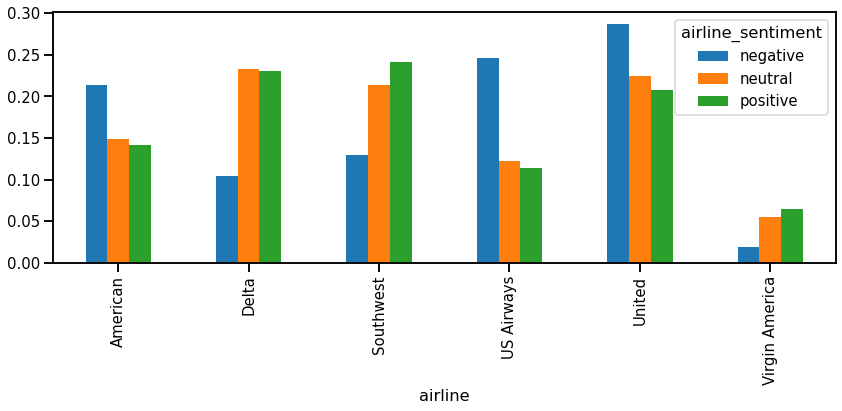

In [52]:
plt.rcParams['figure.figsize'] = (12, 6)
pd.crosstab(df1.airline, df1.airline_sentiment, normalize='columns').plot(kind='bar');
plt.tight_layout(pad=1.1)

plt.savefig('airlines_tweets.png', facecolor='w')

In [21]:
df1['airline_sentiment'].value_counts(normalize=True)*100


negative    62.691257
neutral     21.168033
positive    16.140710
Name: airline_sentiment, dtype: float64

In [22]:
df1['airline'].value_counts(normalize=True)*100


United            26.106557
US Airways        19.897541
American          18.845628
Southwest         16.530055
Delta             15.177596
Virgin America     3.442623
Name: airline, dtype: float64

In [23]:
#sampling only negative sentiments

df1.query("airline_sentiment == 'negative'").sample(5, random_state=423)[['text']]


text
12485                                     @AmericanAir Policy makers need to change their mindset on aviation. Flying is not for... http://t.co/DQnn0Rf1V8
7149                                                But, are your flight attendants fucking tho? RT @JetBlue: Our fleet's on fleek. http://t.co/wGYzTnjCXm
9777           @USAirways your service at PHL is abysmal. An hour on the runway waiting for a gate, no information anywhere, missed my connection abysmal!
1972   @united - you rebooked me to UA1764 after UA 3883 was Cancelled Flightled. I paid for first class ticket - but new seat is 38E. Can you please fix!
7521                                                        @JetBlue if someone had bothered to inform us that the airport closed, that would have helped.

 - Looks indeed negative

In [24]:
#sampling only positive sentiments

df1.query("airline_sentiment == 'positive'").sample(5, random_state=42)[['text']]


text
6396                           @SouthwestAir thanks for your excellent response time and assistance! All set :)
8484                                                        @JetBlue thanks. I appreciate your prompt response.
8417   @JetBlue yes, with about 20 minutes to spare.  FYI - your employees are amazing.  Keep up the good work!
11553                                             @USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏
8106                                                                    @JetBlue beautiful ride. Thanks again:)

- Looks indeed positive, lots of emojies that need to be converted into text

In [25]:
df1.query("airline_sentiment == 'neutral'").sample(5, random_state=422)[['text']]


text
6765    @JetBlue Yeah I have! I'm on it!! Looking for specific dates - I will just keep checking daily for a fare drop
4877                                                            .@SouthwestAir Well, we all need something to aim for.
8145                       @JetBlue Airways Hits New 12-Month High at $17.58 (JBLU) - WKRB News http://t.co/XvBjCzlMDA
6221                                                                @SouthwestAir just sent you a DM w/ additonal info
10421  @USAirways well, depending on the policy will make the determination as to which airline is selected to travel.

 - Looks 'neutrally' unclear, must be hard to separate from positive and negative (models scores will be decreased). Ideally, the 'neutral' class could be combined with 'positive' one, since they are not 'negative'.

In [26]:
df1.loc[7, ['text']]


text    @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
Name: 7, dtype: object

In [27]:
text=str(df1.loc[7, ['text']])

print('original', text)

t=re.sub(r"http\S+", '', text)
print(t)


original text    @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
Name: 7, dtype: object
text    @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. 
Name: 7, dtype: object


In [28]:
text=str(df1.loc[8, ['text']])

print('original', text)

t=re.sub(r"http\S+", '', text)
print(t)

original text    @virginamerica Well, I didn't…but NOW I DO! :-D
Name: 8, dtype: object
text    @virginamerica Well, I didn't…but NOW I DO! :-D
Name: 8, dtype: object


### Insights:

- Significantly more 'negatives' vs. 'positive' and 'neutral', classes are unbalanced.
- More negatives for larger (older?) airlines, such as United
- More positives for smaller (younger?) airlines, such as Virgin America
- Emoji need to be converted to text, since it is all about sentiments

### Text pre-processing: Data preparation

#### Part A: before Tokenization
 - a. Html tag removal
 - b. Translate emoji
 - c. Replace contructions
 - d. Remove the numbers.

 - e. <b>Tokenization</b>

#### Part B: after Tokenization
 - f. Removal of Non-ASCII, Special Characters and Punctuations
 - g. Conversion to lowercase
 - h. Removal of stopwords
 - i. Lemmitization
 - j. Join the words in the list to convert back to text string in the dataframe
 - k. Print first and last 5 rows of data after pre-processing

### Part A

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin


In [30]:
class PreprocessTransform(BaseEstimator, TransformerMixin):
    '''pipeline estimator sklearn'''
    def __init__(self, remove_numbers=True):
        self.remove_numbers = remove_numbers

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_trans = X.apply(self._preprocess)
        return X_trans
    
    def _preprocess(self, text):
        text = self._strip_html(text)
        text = self._strip_html_text(text)
        text = self._translate_emoji(text)
        text = self._replace_contractions(text)
        if self.remove_numbers:
            text = self._remove_numbers(text)
        
        return text
            
    def _strip_html(self, text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    def _strip_html_text(self, text):       
        text_1=re.sub(r"http\S+", '', str(text))
        return text_1
    
    def _translate_emoji(self, text):
        """Translate emoji into english words"""
        text_1 = emoji.demojize(text)
        text_2 = str(text_1.split('_')) #after emoji conversion, words are joined by "_", which is removed here
        return text_2
    
    def _replace_contractions(self, text):
        """Replace contractions in string of text"""
        return contractions.fix(text)
    
    def _remove_numbers(self, text):
        text = re.sub(r'\d+', '', text)
        return text
    

In [31]:
text=df1.loc[11553, ['text']]
print(text)
print(type(text))


text    @USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏
Name: 11553, dtype: object
<class 'pandas.core.series.Series'>


In [32]:
PreprocessTransform().transform(text)


text    ['@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;):folded', 'hands::folded', 'hands::folded', 'hands::victory', 'hand::victory', 'hand::victory', 'hand::folded', 'hands::folded', 'hands::folded', 'hands:']
Name: 11553, dtype: object

In [33]:
PreprocessTransform().transform(df1.loc[8417, ['text']])


text    ['@JetBlue yes, with about  minutes to spare.  FYI - your employees are amazing.  Keep up the good work!']
Name: 8417, dtype: object

> Removing names of airlines from text not to bias classifications

In [34]:
a_list=np.array(df1['airline'].unique())
airlines_list=[re.sub(' ', '', word) for word in a_list]

adds=['AmericanAir', 'JetBlue', 'SouthwestAir']
airlines_list+=adds
print(len(airlines_list))


9


In [35]:
airlines_list_l=[]
for i in airlines_list:
    i_new=i.lower()
    airlines_list_l.append(i_new)
    
airlines_list_l


['virginamerica',
 'united',
 'southwest',
 'delta',
 'usairways',
 'american',
 'americanair',
 'jetblue',
 'southwestair']

In [36]:
stopwords = stopwords.words('english')

customlist_to_remove = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

customlist_to_add = airlines_list_l 

stopwords = list(set(stopwords) - set(customlist_to_remove))      
stopwords += set(customlist_to_add)


In [37]:
#stopwords


In [38]:
print(type(stopwords), len(stopwords))


<class 'list'> 155


In [39]:
lemmatizer = WordNetLemmatizer()


In [40]:
class TokenizeLemmatize(PreprocessTransform):    
    
    def __init__(self, remove_non_ascii=True):
        self.remove_non_ascii = remove_non_ascii
    
    def transform(self, X, y=None):
        
        tokens = X.apply(nltk.word_tokenize)
        
        normalized_tokens = tokens.apply(self._normalize)
    
        return normalized_tokens


    def _remove_non_ascii(self, words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words

    def _to_lowercase(self, words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words

    def _remove_punctuation(self, words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def _remove_stopwords(self, words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords:
                new_words.append(word)
        return new_words

    def _lemmatize_list(self, words):
        new_words = []
        for word in words:
            new_words.append(lemmatizer.lemmatize(word, pos='v'))
        return new_words
    

    def _normalize(self, words):
        
        if self.remove_non_ascii:
            words = self._remove_non_ascii(words)
            
        words = self._to_lowercase(words)
        words = self._remove_punctuation(words)
        words = self._remove_stopwords(words)
            
        words = self._lemmatize_list(words)
        
        return ' '.join(words)
    

In [41]:
TokenizeLemmatize().transform(df1.loc[9, ['text']])



text    amaze arrive hour early good
Name: 9, dtype: object

In [42]:
df1.loc[8, ['text']]


text    @virginamerica Well, I didn't…but NOW I DO! :-D
Name: 8, dtype: object

In [43]:
nt=TokenizeLemmatize().transform(df1.loc[8, ['text']])
print(nt, len(nt), type(nt))


text    well didntbut
Name: 8, dtype: object 1 <class 'pandas.core.series.Series'>


### Preprocessing Pipelines

In [53]:
df2=df1.copy()


In [54]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')


In [55]:

pipe_steps = [
    ('PreprocessTransform', PreprocessTransform()), # on keywords field
    ('TokenizeLemmatize', TokenizeLemmatize()) # on text field
]


In [56]:
pipe = Pipeline(pipe_steps)
pipe


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize())])

In [57]:
pipe.transform(df2['text'])


0                                                                                     dhepburn say
1                                                            plus add commercials experience tacky
2                                                       not today must mean need take another trip
3                      really aggressive blast obnoxious entertainment guests face little recourse
4                                                                             really big bad thing
                                                   ...                                            
14635                                                           thank get different flight chicago
14636    leave minutes late flight warn communication minutes late flight call shitty customer svc
14637                                                             please bring airlines blackberry
14638                             money change flight not answer phone suggestions make commitment
14639     

In [58]:
df2.tail(3)


airline_sentiment   airline  \
14637           neutral  American   
14638          negative  American   
14639           neutral  American   

                                                                                                                                             text  
14637                                                                                @AmericanAir Please bring American Airlines to #BlackBerry10  
14638     @AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??  
14639  @AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?

In [59]:
pipe.steps[-1][-1].get_params()


{'remove_non_ascii': True}

In [60]:
pipe.set_params(TokenizeLemmatize__remove_non_ascii=True)


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize())])

In [61]:
pipe_steps.append(("CountVectorizer", CountVectorizer()))
pipe2 = Pipeline(pipe_steps)
pipe2


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize()),
                ('CountVectorizer', CountVectorizer())])

In [62]:
pipe2.fit_transform(df2['text'])


<14640x10979 sparse matrix of type '<class 'numpy.int64'>'
	with 125717 stored elements in Compressed Sparse Row format>

In [63]:
pipe2.named_steps['CountVectorizer'].get_feature_names()


['aa',
 'aaaand',
 'aaadvantage',
 'aaalwayslate',
 'aaba',
 'aacom',
 'aacustomerservice',
 'aadavantage',
 'aadelay',
 'aadv',
 'aadvantage',
 'aafail',
 'aal',
 'aano',
 'aaron',
 'aarp',
 'aaso',
 'aateam',
 'aaus',
 'ab',
 'aback',
 'abandon',
 'abandonment',
 'abassinet',
 'abbreve',
 'abc',
 'abcdef',
 'abcletjetbluestreamfeed',
 'abcnetwork',
 'abcnews',
 'abcnewsbayarea',
 'abduct',
 'abi',
 'abidfw',
 'abigailedge',
 'abilities',
 'ability',
 'able',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'abroad',
 'absolute',
 'absolutely',
 'absorb',
 'absorber',
 'absoulutely',
 'absurd',
 'absurdity',
 'absurdly',
 'abt',
 'abundance',
 'abuse',
 'abysmal',
 'ac',
 'acarl',
 'acc',
 'accelerate',
 'accept',
 'acceptable',
 'acces',
 'access',
 'accessibility',
 'accessible',
 'accident',
 'accidentally',
 'accidents',
 'accomidating',
 'accommodate',
 'accommodation',
 'accommodations',
 'accompaniments',
 'accompany',
 'accomplish',
 'accord',
 'accordingly',
 'account',
 'accountabi

In [64]:
pipe_steps.append(('clf', LogisticRegression(random_state=856, 
                        solver='liblinear',   
                        max_iter=100)))

pipe3 = Pipeline(pipe_steps)
pipe3


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize()),
                ('CountVectorizer', CountVectorizer()),
                ('clf',
                 LogisticRegression(random_state=856, solver='liblinear'))])

### Classification from the pipe

In [65]:
df2['sentiment_score'] = 0
df2.loc[(df2['airline_sentiment']=='negative'), 'sentiment_score'] = -1
df2.loc[(df2['airline_sentiment']=='positive'), 'sentiment_score'] = 1

df2.head()


airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                                                                                             text  \
0                                                                                             @VirginAmerica What @dhepburn said.   
1                                                        @VirginAmerica plus you've added commercials to the experience... tacky.   
2                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!   
3  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse   
4                                                                         @VirginAmerica and it's a really big bad thing about it   

   sentiment_score  
0                0  
1                1  
2                0  
3               -1  
4               -1

In [66]:
X = df2['text']

y = df2['sentiment_score']
y = y.astype(int)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=887,  stratify=y)


In [68]:
print(X_train.shape, y_train.shape)


(10980,) (10980,)


In [69]:
pipe3.fit(X_train, y_train)


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize()),
                ('CountVectorizer', CountVectorizer()),
                ('clf',
                 LogisticRegression(random_state=856, solver='liblinear'))])

In [70]:
pred_1 = pipe3.predict(X_test)


In [71]:
print(classification_report(y_test, pred_1))


              precision    recall  f1-score   support

          -1       0.84      0.90      0.87      2294
           0       0.61      0.54      0.57       775
           1       0.74      0.64      0.69       591

    accuracy                           0.78      3660
   macro avg       0.73      0.69      0.71      3660
weighted avg       0.77      0.78      0.78      3660



In [72]:
print(np.mean(cross_val_score(pipe3, X_test, y_test, cv=5)))


0.7653005464480873


In [88]:
conf_mat = confusion_matrix(y_test, pred_1)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['-1','0','1']],
                  columns = [i for i in ['-1','0','1']])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, 
            annot=True, 
            fmt='g',
            xticklabels=['neg_act','neut_act','pos_act'],
            yticklabels=['neg_pr','neut_pr','pos_pr'],
           )

[[2062  171   61]
 [ 286  415   74]
 [ 121   89  381]]


### Hyperparameters Tuning

In [74]:
from sklearn.model_selection import StratifiedKFold


In [75]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=887)


In [76]:
pipe3


Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize()),
                ('CountVectorizer', CountVectorizer()),
                ('clf',
                 LogisticRegression(random_state=856, solver='liblinear'))])

In [77]:
from sklearn.model_selection import GridSearchCV


In [90]:
param_grid = dict(
            PreprocessTransform__remove_numbers=[True, False],
            CountVectorizer__max_features=[1500, 2000],
            CountVectorizer__max_df=[0.7, 0.5],
            clf__class_weight=[{-1:0.1, 0:0.6, 1:0.3}, {-1:0.1, 0:0.8, 1:0.1}],
            clf__fit_intercept=[True, False])
param_grid


{'PreprocessTransform__remove_numbers': [True, False],
 'CountVectorizer__max_features': [1500, 2000],
 'CountVectorizer__max_df': [0.7, 0.5],
 'clf__class_weight': [{-1: 0.1, 0: 0.6, 1: 0.3}, {-1: 0.1, 0: 0.8, 1: 0.1}],
 'clf__fit_intercept': [True, False]}

In [91]:
gridsearch = GridSearchCV(pipe3, param_grid, scoring='f1_weighted', cv=kfold, 
             n_jobs=-1, verbose=3)
gridsearch


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=856,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf__class_weight': [{-1: 0.1, 0: 0.6, 1: 0.3},
                                               {-1: 0.1, 0: 0.8, 1: 0.1}],
                         'clf__fit_intercept': [True, False]},
             scoring='f1_weighted', verbose=3)

In [92]:
gridsearch.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=856,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf__class_weight': [{-1: 0.1, 0: 0.6, 1: 0.3},
                                               {-1: 0.1, 0: 0.8, 1: 0.1}],
                         'clf__fit_intercept': [True, False]},
             scoring='f1_weighted', verbose=3)

In [93]:
pred_gs = gridsearch.predict(X_test)
print(classification_report(y_test, pred_gs))


              precision    recall  f1-score   support

          -1       0.89      0.81      0.85      2294
           0       0.53      0.71      0.60       775
           1       0.72      0.66      0.69       591

    accuracy                           0.76      3660
   macro avg       0.71      0.73      0.71      3660
weighted avg       0.79      0.76      0.77      3660



In [94]:
print(gridsearch.best_params_)


{'CountVectorizer__max_df': 0.7, 'CountVectorizer__max_features': 2000, 'PreprocessTransform__remove_numbers': False, 'clf__class_weight': {-1: 0.1, 0: 0.6, 1: 0.3}, 'clf__fit_intercept': True}


[[1850  361   83]
 [ 154  549   72]
 [  67  133  391]]


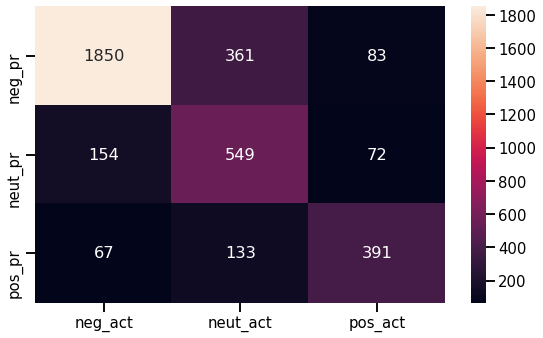

In [95]:
conf_mat = confusion_matrix(y_test, pred_gs)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['-1','0','1']],
                  columns = [i for i in ['-1','0','1']])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, 
            annot=True, 
            fmt='g',
            xticklabels=['neg_act','neut_act','pos_act'],
            yticklabels=['neg_pr','neut_pr','pos_pr'],
           )

plt.tight_layout(pad=1.1)

plt.savefig('confus_matrix_3classes.png', facecolor='w')

### Combining 'neutral' group with 'positive', as being non-negative
 - 'Neutral' group sometime seems to be assigned to a not-very-clear cooments (even for humans). 
 - If the main goal is to isolate 'negative' group, classification will be more precise

In [96]:
df2.tail()


airline_sentiment   airline  \
14635          positive  American   
14636          negative  American   
14637           neutral  American   
14638          negative  American   
14639           neutral  American   

                                                                                                                                                         text  \
14635                                                                                         @AmericanAir thank you we got on a different flight to Chicago.   
14636  @AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc   
14637                                                                                            @AmericanAir Please bring American Airlines to #BlackBerry10   
14638                 @AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??   
14639              @AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?   

       sentiment_score  
14635                1  
14636               -1  
14637                0  
14638               -1  
14639                0

In [97]:
df3=df2.copy()

df3.loc[df3['sentiment_score']==0, 'sentiment_score']=1

df3.tail()


airline_sentiment   airline  \
14635          positive  American   
14636          negative  American   
14637           neutral  American   
14638          negative  American   
14639           neutral  American   

                                                                                                                                                         text  \
14635                                                                                         @AmericanAir thank you we got on a different flight to Chicago.   
14636  @AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc   
14637                                                                                            @AmericanAir Please bring American Airlines to #BlackBerry10   
14638                 @AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??   
14639              @AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?   

       sentiment_score  
14635                1  
14636               -1  
14637                1  
14638               -1  
14639                1

In [98]:
print('previous groups', df2['sentiment_score'].value_counts(normalize=True))
print('combined groups', df3['sentiment_score'].value_counts(normalize=True))


previous groups -1    0.626913
 0    0.211680
 1    0.161407
Name: sentiment_score, dtype: float64
combined groups -1    0.626913
 1    0.373087
Name: sentiment_score, dtype: float64


### Classifier re-built

In [99]:
X = df3['text']

y = df3['sentiment_score']
y = y.astype(int)


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=887,  stratify=y)
print(X_train.shape, y_train.shape)


(10980,) (10980,)


In [101]:
param_grid_new = dict(
            PreprocessTransform__remove_numbers=[True, False],
            CountVectorizer__max_features=[1500, 2000],
            CountVectorizer__max_df=[0.7, 0.5],
            clf__class_weight=[{-1:0.2, 1:0.8}, {-1:0.4, 1:0.6}],
            clf__fit_intercept=[True, False])
param_grid_new


{'PreprocessTransform__remove_numbers': [True, False],
 'CountVectorizer__max_features': [1500, 2000],
 'CountVectorizer__max_df': [0.7, 0.5],
 'clf__class_weight': [{-1: 0.2, 1: 0.8}, {-1: 0.4, 1: 0.6}],
 'clf__fit_intercept': [True, False]}

In [102]:
gridsearch_new = GridSearchCV(pipe3, param_grid_new, scoring='f1_weighted', cv=kfold, 
             n_jobs=-1, verbose=3)
gridsearch_new


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=856,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf__class_weight': [{-1: 0.2, 1: 0.8},
                                               {-1: 0.4, 1: 0.6}],
                         'clf__fit_intercept': [True, False]},
             scoring='f1_weighted', verbose=3)

In [103]:
gridsearch_new.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=856,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf__class_weight': [{-1: 0.2, 1: 0.8},
                                               {-1: 0.4, 1: 0.6}],
                         'clf__fit_intercept': [True, False]},
             scoring='f1_weighted', verbose=3)

In [104]:
pred_gs_new = gridsearch_new.predict(X_test)
print(classification_report(y_test, pred_gs_new))


              precision    recall  f1-score   support

          -1       0.89      0.83      0.86      2294
           1       0.75      0.83      0.79      1366

    accuracy                           0.83      3660
   macro avg       0.82      0.83      0.82      3660
weighted avg       0.84      0.83      0.83      3660



In [105]:
print(gridsearch_new.best_params_)


{'CountVectorizer__max_df': 0.7, 'CountVectorizer__max_features': 2000, 'PreprocessTransform__remove_numbers': True, 'clf__class_weight': {-1: 0.4, 1: 0.6}, 'clf__fit_intercept': True}


[[1913  381]
 [ 233 1133]]


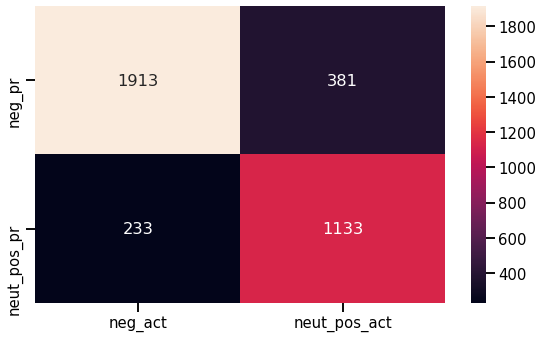

In [106]:
conf_mat = confusion_matrix(y_test, pred_gs_new)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['-1','1']],
                  columns = [i for i in ['-1','1']])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, 
            annot=True, 
            fmt='g',
            xticklabels=['neg_act','neut_pos_act'],
            yticklabels=['neg_pr','neut_pos_pr'],
           )

plt.tight_layout(pad=1.1)

plt.savefig('confus_matrix_2classes.png', facecolor='w')


### Decision Tree modeling

In [107]:
from sklearn.tree import DecisionTreeClassifier

In [108]:
dtcl = DecisionTreeClassifier(random_state=559)

In [109]:
dtcl.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [112]:
pipe_steps.append(('clf_dt', dtcl))
pipe_steps

[('PreprocessTransform', PreprocessTransform()),
 ('TokenizeLemmatize', TokenizeLemmatize()),
 ('CountVectorizer', CountVectorizer()),
 ('clf', LogisticRegression(random_state=856, solver='liblinear')),
 ('clf_dt', DecisionTreeClassifier(random_state=559))]

In [113]:
pipe_steps.pop(3)
pipe_steps

[('PreprocessTransform', PreprocessTransform()),
 ('TokenizeLemmatize', TokenizeLemmatize()),
 ('CountVectorizer', CountVectorizer()),
 ('clf_dt', DecisionTreeClassifier(random_state=559))]

In [114]:
pipe4 = Pipeline(pipe_steps)
pipe4

Pipeline(steps=[('PreprocessTransform', PreprocessTransform()),
                ('TokenizeLemmatize', TokenizeLemmatize()),
                ('CountVectorizer', CountVectorizer()),
                ('clf_dt', DecisionTreeClassifier(random_state=559))])

In [115]:
param_grid_dt = dict(
            PreprocessTransform__remove_numbers=[True, False],
            CountVectorizer__max_features=[1500, 2000],
            CountVectorizer__max_df=[0.7, 0.5],
            clf_dt__class_weight=[{-1:0.2, 1:0.8}, {-1:0.4, 1:0.6}],
            clf_dt__criterion=["gini", "entropy"])
param_grid_dt


{'PreprocessTransform__remove_numbers': [True, False],
 'CountVectorizer__max_features': [1500, 2000],
 'CountVectorizer__max_df': [0.7, 0.5],
 'clf_dt__class_weight': [{-1: 0.2, 1: 0.8}, {-1: 0.4, 1: 0.6}],
 'clf_dt__criterion': ['gini', 'entropy']}

In [116]:
gridsearch_dt = GridSearchCV(pipe4, param_grid_dt, scoring='f1_weighted', cv=kfold, 
             n_jobs=-1, verbose=3)
gridsearch_dt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf_dt',
                                        DecisionTreeClassifier(random_state=559))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf_dt__class_weight': [{-1: 0.2, 1: 0.8},
                                                  {-1: 0.4, 1: 0.6}],
                         'clf_dt__criterion': ['gini', 'entropy']},
             scoring='f1_weighted', verbose=3)

In [117]:
gridsearch_dt.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=887, shuffle=True),
             estimator=Pipeline(steps=[('PreprocessTransform',
                                        PreprocessTransform()),
                                       ('TokenizeLemmatize',
                                        TokenizeLemmatize()),
                                       ('CountVectorizer', CountVectorizer()),
                                       ('clf_dt',
                                        DecisionTreeClassifier(random_state=559))]),
             n_jobs=-1,
             param_grid={'CountVectorizer__max_df': [0.7, 0.5],
                         'CountVectorizer__max_features': [1500, 2000],
                         'PreprocessTransform__remove_numbers': [True, False],
                         'clf_dt__class_weight': [{-1: 0.2, 1: 0.8},
                                                  {-1: 0.4, 1: 0.6}],
                         'clf_dt__criterion': ['gini', 'entropy']},
             scoring='f1_weighted', verbose=3)

In [118]:
pred_gs_dt = gridsearch_dt.predict(X_test)
print(classification_report(y_test, pred_gs_dt))

              precision    recall  f1-score   support

          -1       0.83      0.78      0.81      2294
           1       0.67      0.74      0.70      1366

    accuracy                           0.76      3660
   macro avg       0.75      0.76      0.75      3660
weighted avg       0.77      0.76      0.77      3660



In [119]:
print(gridsearch_dt.best_params_)

{'CountVectorizer__max_df': 0.7, 'CountVectorizer__max_features': 2000, 'PreprocessTransform__remove_numbers': True, 'clf_dt__class_weight': {-1: 0.2, 1: 0.8}, 'clf_dt__criterion': 'entropy'}


[[1793  501]
 [ 360 1006]]


<AxesSubplot:>

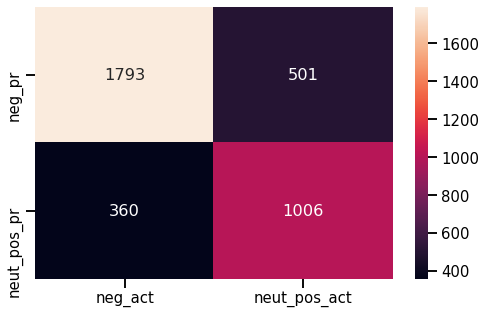

In [120]:
conf_mat = confusion_matrix(y_test, pred_gs_dt)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['-1','1']],
                  columns = [i for i in ['-1','1']])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, 
            annot=True, 
            fmt='g',
            xticklabels=['neg_act','neut_pos_act'],
            yticklabels=['neg_pr','neut_pos_pr'],
           )

#### Insights:
 - Logistic Regression performed better than Decision Tree algorithm.
 

### Summary:

- Airlines sentiments scraped from tweets were analyzed using text reviews in and their sentiment score on the scale of 'negative', 'neutral' and 'postive for text classification modeling.
- Built text pre-processing pipelines for:
  - Part A: removing html tags, numbers (on/off), translating emojis, replacing contractions
  - Part B: tokenization, removing punctuation, non-ascii, stopwords, lemmitization and joining words
- 'Bag of words' using CountVectorizer.

- Logisitic Regression was found to perform better (f1-score=0.83) vs. Decision Tree (f1-score=0.77).

